### Import Libraries

In [7]:
import numpy as np
import pandas as pd
import time 

import matplotlib.pyplot as plt

# from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.cluster import KMeans
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from scipy.stats import kurtosis

from scipy.spatial.distance import cdist

from textwrap import wrap

### Load Dataset

In [8]:
RANDOM_SEED = 25


columns = ['Radius','Texture','Perimeter','Area','Smoothness','Compactness',
           'Concavity','Concave_Points','Symmetry','Fractal_Dimension',
           'Malignant/Benign']

# Read CSV file into pandas df
df = pd.read_csv('../datasets/breast_cancer/breast-cancer-wisconsin.csv',
                 delimiter=',', quotechar='"', names=columns)

### Dataframe without Preprocessing 

In [9]:
print("Printing dataframe head (without any preprocessing)....")
print(df.head(10))

Printing dataframe head (without any preprocessing)....
    Radius  Texture  Perimeter  Area  Smoothness  Compactness Concavity  \
0  1000025        5          1     1           1            2         1   
1  1002945        5          4     4           5            7        10   
2  1015425        3          1     1           1            2         2   
3  1016277        6          8     8           1            3         4   
4  1017023        4          1     1           3            2         1   
5  1017122        8         10    10           8            7        10   
6  1018099        1          1     1           1            2        10   
7  1018561        2          1     2           1            2         1   
8  1033078        2          1     1           1            2         1   
9  1033078        4          2     1           1            2         1   

   Concave_Points  Symmetry  Fractal_Dimension  Malignant/Benign  
0               3         1                  1     

### Dataset Preprocessing 

In [10]:
# Shuffle
df = shuffle(df, random_state=RANDOM_SEED)

# DROP USELESS ROWS AND COLUMNS
df.dropna(inplace=True)
cols = [0]
# Drop ID column (it's not attribute or target)
df.drop(df.columns[cols],axis=1,inplace=True)
# Drop all data points with missing variables  (denoted by '?' entry)
nostrings_row_list = [x.isdigit() for x in df.iloc[:,5]]
df = df[nostrings_row_list]


# Handle categorical data
# df = pd.get_dummies(df)


# Split data into X and y vectors
X = df.ix[:, df.columns != 'Malignant/Benign']
y = df['Malignant/Benign']

# Change 2 -> 0 (benign) and 4 -> 1 (malignant)
y.replace(2, 0, inplace=True)
y.replace(4, 1, inplace=True)


/home/saksham/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


### Sanity Check on Dataframe 


In [11]:
print("Sanity Check: Printing out dataframe and shape after preprocessing... ")
print(df.head(10))
print("df.shape: ", df.shape)


Sanity Check: Printing out dataframe and shape after preprocessing... 
     Texture  Perimeter  Area  Smoothness  Compactness Concavity  \
437        4          1     1           1            2         1   
511        5          1     1           1            2         1   
215        8          7     8           7            5         5   
684        1          1     1           1            2         1   
302       10         10    10           7            9        10   
341        1          1     1           1            2         1   
608        5         10    10          10           10        10   
366        6         10    10          10            8        10   
205        5         10    10           9            6        10   
270        8          4     7           1            3        10   

     Concave_Points  Symmetry  Fractal_Dimension  Malignant/Benign  
437               1         1                  1                 0  
511               2         1             

### Training and Testing Split, Scaling 

In [12]:
# # Split into 30%  training data, 70% testing data
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=0.30, random_state=RANDOM_SEED)


# # Apply scaling. Large values of certain features undesireable for NN
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

### Sanity Check on X

In [13]:
print(X)

     Texture  Perimeter  Area  Smoothness  Compactness Concavity  \
437        4          1     1           1            2         1   
511        5          1     1           1            2         1   
215        8          7     8           7            5         5   
684        1          1     1           1            2         1   
302       10         10    10           7            9        10   
341        1          1     1           1            2         1   
608        5         10    10          10           10        10   
366        6         10    10          10            8        10   
205        5         10    10           9            6        10   
270        8          4     7           1            3        10   
586        8         10    10          10            6        10   
264        7          9     4          10           10         3   
554        3          1     1           1            2         1   
509        2          1     1           1       

### RP - (Followed by Clustering Later)

In [37]:
# How many times to repeat RP 
RP_iterations = 10

# Specify number of eignevectors to use for PCA 
n_comp_list = range(1, 10)
min_error_list = []

for n_comp in n_comp_list: 

    rp = GaussianRandomProjection(n_components=n_comp)
    rp = rp.fit(X)
    X_dim_reduced = rp.transform(X)

    clf_dimReduced = KMeans(n_clusters=2, random_state=0)
    clf_dimReduced.fit(X_dim_reduced)
    error_dimReduced = mean_squared_error(y, clf_dimReduced.predict(X_dim_reduced))

    min_error = error_dimReduced


    for _ in range(1, RP_iterations): 

        rp = GaussianRandomProjection(n_components=n_comp)
        rp = rp.fit(X)
        X_dim_reduced = rp.transform(X)

        clf_dimReduced = KMeans(n_clusters=2, random_state=0)
        clf_dimReduced.fit(X_dim_reduced)
        error_dimReduced = mean_squared_error(y, clf_dimReduced.predict(X_dim_reduced))
        min_error = min(min_error, error_dimReduced) 

    min_error_list.append(min_error)

print(min_error_list)
print(len(min_error_list))

[0.05417276720351391, 0.040995607613469986, 0.04978038067349927, 0.0424597364568082, 0.0424597364568082, 0.03953147877013177, 0.043923865300146414, 0.036603221083455345, 0.040995607613469986]
9


### Plot MSE for k-means with change no. of components for RP

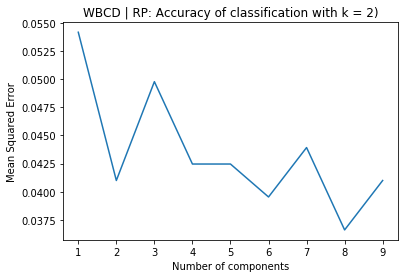

In [38]:
plt.plot(n_comp_list, min_error_list, '-')
plt.title('WBCD | RP: Accuracy of classification with k = 2)')
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.savefig('WBCD_RP_K-means.png')
plt.show()

### Clustering after RP (EM)

In [33]:
# How many times to repeat RP 
RP_iterations = 10

# Specify number of eignevectors to use for PCA 
n_comp_list = range(1, 10)
min_error_list = []

for n_comp in n_comp_list: 

    print("Running experiment for n_comp = ", n_comp)
    rp = GaussianRandomProjection(n_components=n_comp)
    rp = rp.fit(X)
    X_dim_reduced = rp.transform(X)
    
    fitter = GaussianMixture(n_components=2,covariance_type='full',n_init=10,max_iter=200)
    fitter.fit(X_dim_reduced)
    error_dimReduced = mean_squared_error(y, fitter.predict(X_dim_reduced))

    min_error = error_dimReduced


    for _ in range(1, RP_iterations): 

        rp = GaussianRandomProjection(n_components=n_comp)
        rp = rp.fit(X)
        X_dim_reduced = rp.transform(X)

        fitter = GaussianMixture(n_components=2,covariance_type='full',n_init=10,max_iter=200)
        fitter.fit(X_dim_reduced)
        error_dimReduced = mean_squared_error(y, fitter.predict(X_dim_reduced))
        min_error = min(min_error, error_dimReduced) 

    min_error_list.append(min_error)

print(min_error_list)
print(len(min_error_list))


Running experiment for n_comp =  1
Running experiment for n_comp =  2
Running experiment for n_comp =  3
Running experiment for n_comp =  4
Running experiment for n_comp =  5
Running experiment for n_comp =  6
Running experiment for n_comp =  7
Running experiment for n_comp =  8
Running experiment for n_comp =  9
[0.10834553440702782, 0.0746705710102489, 0.09809663250366032, 0.1171303074670571, 0.10980966325036604, 0.1273792093704246, 0.1581259150805271, 0.13030746705710103, 0.12445095168374817]
9


### Plot MSE for EM with change no. of components for RP

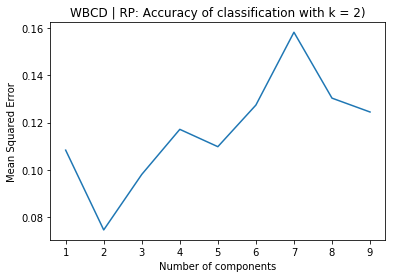

In [34]:
plt.plot(n_comp_list, min_error_list, '-')
plt.title('WBCD | RP: Accuracy of classification with k = 2)')
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.savefig('WBCD_RP_K-means.png')
plt.show()

### Compare clustering with k = 2 (Dim reduced k-means, vs just k-means)

In [37]:
# Specify number of eignevectors to use for PCA 
# n_comp_list = range(1, 10)

errorlist = []
errorlist_dimReduced = []

for n_comp in range(1,10): 
    pca = PCA(n_components=n_comp)
    X_dim_reduced = pca.fit(X).transform(X)
    print(pca.explained_variance_ratio_)

    # Without PCA
    clf_dimReduced = KMeans(n_clusters=2, random_state=0)
    clf_dimReduced.fit(X)
    error = mean_squared_error(y, clf_dimReduced.predict(X))
    errorlist.append(error)
    print("Printing error without PCA ... ", error)
    
    # After PCA
    clf_dimReduced = KMeans(n_clusters=2, random_state=0)
    clf_dimReduced.fit(X_dim_reduced)
    error_dimReduced = mean_squared_error(y, clf_dimReduced.predict(X_dim_reduced))
    errorlist_dimReduced.append(error_dimReduced)
    print("Printing error_dimReduced ... ", error_dimReduced)

[0.69050756]
Printing error without PCA ...  0.03953147877013177
Printing error_dimReduced ...  0.03806734992679356
[0.69050756 0.07195066]
Printing error without PCA ...  0.03953147877013177
Printing error_dimReduced ...  0.03953147877013177
[0.69050756 0.07195066 0.06055921]
Printing error without PCA ...  0.03953147877013177
Printing error_dimReduced ...  0.03953147877013177
[0.69050756 0.07195066 0.06055921 0.04442012]
Printing error without PCA ...  0.03953147877013177
Printing error_dimReduced ...  0.03806734992679356
[0.69050756 0.07195066 0.06055921 0.04442012 0.03900513]
Printing error without PCA ...  0.03953147877013177
Printing error_dimReduced ...  0.03953147877013177
[0.69050756 0.07195066 0.06055921 0.04442012 0.03900513 0.03443899]
Printing error without PCA ...  0.03953147877013177
Printing error_dimReduced ...  0.03953147877013177
[0.69050756 0.07195066 0.06055921 0.04442012 0.03900513 0.03443899
 0.02529478]
Printing error without PCA ...  0.03953147877013177
Printin

In [39]:
print(min(errorlist))
print(min(errorlist_dimReduced))

0.03953147877013177
0.03806734992679356


In [28]:
print(X_dim_reduced.shape)

(683, 1)


### EM Clustering after PCA (when k = 2) 

In [41]:
errorlist = []
errorlist_dimReduced = []

for n_comp in range(1,10): 
    
    pca = PCA(n_components=n_comp)
    X_dim_reduced = pca.fit(X).transform(X)
    print(pca.explained_variance_ratio_)

    # Without PCA
    fitter = GaussianMixture(n_components=2,covariance_type='full',n_init=10,max_iter=200).fit(X)
    fitter.fit(X)
    error = mean_squared_error(y, fitter.predict(X))
    errorlist.append(error)
    print("Printing error without PCA ... ", error)
    
    # After PCA
    fitter_dimReduced= GaussianMixture(n_components=2,covariance_type='full',n_init=10,max_iter=200).fit(X)
    fitter_dimReduced.fit(X_dim_reduced)
    error_dimReduced = mean_squared_error(y, fitter_dimReduced.predict(X_dim_reduced))
    errorlist_dimReduced.append(error_dimReduced)
    print("Printing error_dimReduced ... ", error_dimReduced)

[0.69050756]
Printing error without PCA ...  0.12298682284040996
Printing error_dimReduced ...  0.9546120058565154
[0.69050756 0.07195066]
Printing error without PCA ...  0.12298682284040996
Printing error_dimReduced ...  0.09956076134699854
[0.69050756 0.07195066 0.06055921]
Printing error without PCA ...  0.87701317715959
Printing error_dimReduced ...  0.12005856515373353
[0.69050756 0.07195066 0.06055921 0.04442012]
Printing error without PCA ...  0.87701317715959
Printing error_dimReduced ...  0.15226939970717424
[0.69050756 0.07195066 0.06055921 0.04442012 0.03900513]
Printing error without PCA ...  0.12298682284040996
Printing error_dimReduced ...  0.8316251830161054
[0.69050756 0.07195066 0.06055921 0.04442012 0.03900513 0.03443899]
Printing error without PCA ...  0.87701317715959
Printing error_dimReduced ...  0.17423133235724744
[0.69050756 0.07195066 0.06055921 0.04442012 0.03900513 0.03443899
 0.02529478]
Printing error without PCA ...  0.12298682284040996
Printing error_dim

In [42]:
print(min(errorlist))
print(min(errorlist_dimReduced))

0.12298682284040996
0.09956076134699854
